# Task 2

In [ ]:
!pip install shap
!pip install dice-ml
!pip install matplotlib
!pip install imbalanced-learn

In [4]:
import shap
import dice_ml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


In [5]:
# Data Loading
# path = r'D:\Masters\Sem 1\WQF7009_xai\AA\archive\diabetes.csv'
path = './archive/diabetes.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [7]:
# Data Preparation
x = df.drop(columns=['Outcome'])
y = df['Outcome']

# Handling Imbalanced Data using SMOTE
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Model Training
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth = 2, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Accuracy: 0.7987012987012987
F1 Score: 0.7394957983193278
RMSE: 0.44866323818505716


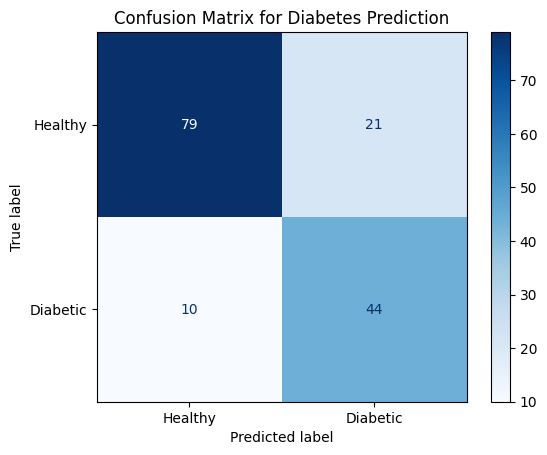

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diabetic'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Diabetes Prediction")
plt.show()

ROC AUC 0.851851851851852


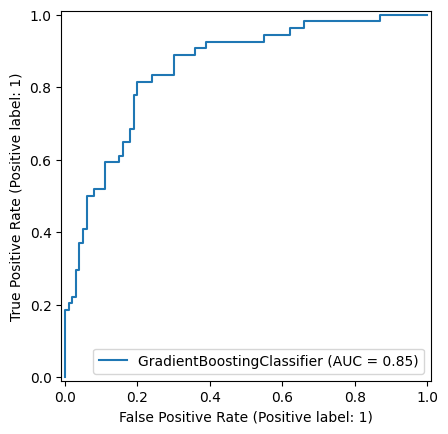

In [10]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
print('ROC AUC', RocCurveDisplay.from_estimator(model, X_test, y_test).roc_auc)
plt.show()

# Task 3

## Feature Importance Explanation - SHAP

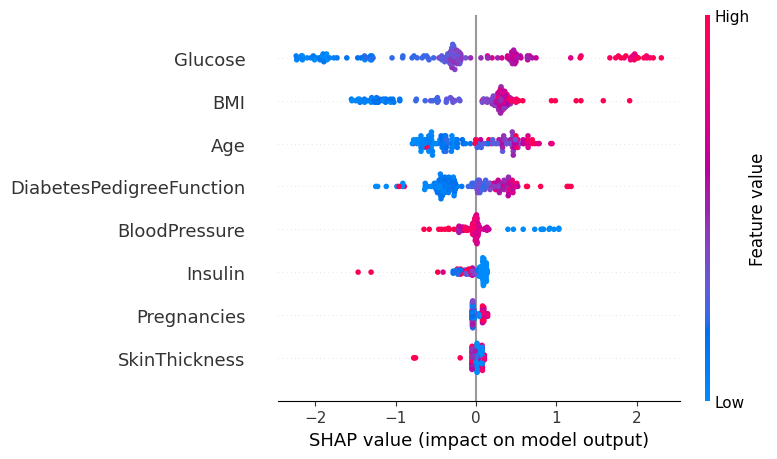

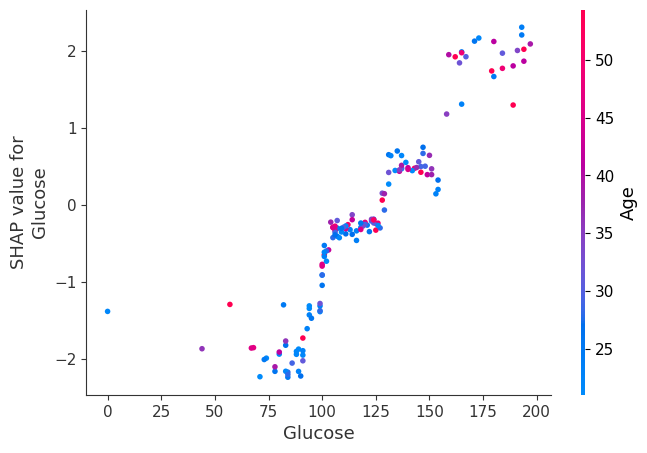

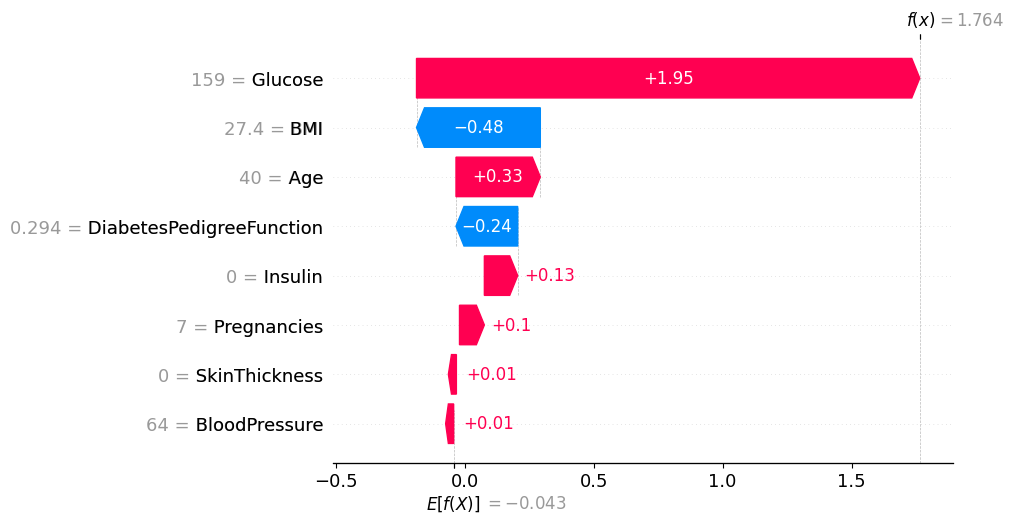

In [11]:
# SHAP Explanations
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test) # global explanation
shap.dependence_plot('Glucose', shap_values.values, X_test) # feature dependence plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test.iloc[0,:]) # local explanation
shap.plots.waterfall(shap_values[0])

## Counterfactual Explanations - DiCE

In [13]:
# DiCE Counterfactual Explanations
d = dice_ml.Data(dataframe=pd.concat([X_train, y_train], axis=1), 
                continuous_features=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], 
                outcome_name='Outcome')
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
query_instance = X_test.iloc[0:1]
genetic_test_df = exp.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")
genetic_test_df.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00, 19.21it/s]

Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,159,64,0,0,27.4,0.294,40,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,159,64,0,669,27.4,0.294,40,0
1,7,40,64,0,0,27.4,0.294,40,0
2,7,129,54,0,0,27.4,0.294,40,0
